In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


## Loading data

In [2]:
train = np.load('fashion_train.npy')
test = np.load('fashion_test.npy')

## Finding X,Y

In [3]:
def find_x_y(data):
    Y = data[:, -1]
    X = np.delete(data, -1, axis=1)
    return X, Y

label_dict = {0: 'T_shirts', 1: 'Trouseres', 2: 'Pullover', 3: 'Dress', 4: 'Shirt'}

train_x, train_y = find_x_y(train)
test_x, test_y = find_x_y(test)

## Normalizing data

In [4]:
train_x = train_x.reshape((10000, 28, 28, 1))
train_x = train_x.astype('float32') / 255

test_x = test_x.reshape((5000, 28, 28, 1))
test_x = test_x.astype('float32') / 255

Converting the class labels into a one-hot encoded representation

In [5]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

## Building the model

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dense(5, activation='softmax'))
#model.add(layers.BatchNormalization())
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1152)             

## Compiling the model

In [7]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Learning rate scheduler

In [8]:
def lr_schedule(epoch):
    """
    Returns a custom learning rate that decreases as epochs progress.
    """
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * drop ** (epoch / epochs_drop)
    return lr

# Set up the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

## Early stopping

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## Checkpoint

In [10]:
#Set up a ModelCheckpoint to save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

## Training and testing

In [11]:
#Training the model
history = model.fit(train_x, train_y, epochs=50, batch_size=32, validation_data=(test_x, test_y), callbacks=[lr_scheduler,early_stopping,checkpoint])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy:', test_acc)

Epoch 1/50


309/313 [============================>.] - ETA: 0s - loss: 0.6364 - accuracy: 0.7396
Epoch 1: val_accuracy improved from -inf to 0.82600, saving model to best_model.h5
313/313 [==============================] - 5s 12ms/step - loss: 0.6344 - accuracy: 0.7407 - val_loss: 0.4660 - val_accuracy: 0.8260 - lr: 0.0010
Epoch 2/50
 19/313 [>.............................] - ETA: 2s - loss: 0.4373 - accuracy: 0.8405

C:\Users\kubic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


311/313 [============================>.] - ETA: 0s - loss: 0.3982 - accuracy: 0.8476
Epoch 2: val_accuracy improved from 0.82600 to 0.85380, saving model to best_model.h5
313/313 [==============================] - 3s 11ms/step - loss: 0.3982 - accuracy: 0.8474 - val_loss: 0.3996 - val_accuracy: 0.8538 - lr: 8.7055e-04
Epoch 3/50
308/313 [============================>.] - ETA: 0s - loss: 0.3492 - accuracy: 0.8695
Epoch 3: val_accuracy improved from 0.85380 to 0.86680, saving model to best_model.h5
313/313 [==============================] - 3s 11ms/step - loss: 0.3491 - accuracy: 0.8692 - val_loss: 0.3741 - val_accuracy: 0.8668 - lr: 7.5786e-04
Epoch 4/50
311/313 [============================>.] - ETA: 0s - loss: 0.3050 - accuracy: 0.8851
Epoch 4: val_accuracy improved from 0.86680 to 0.87400, saving model to best_model.h5
313/313 [==============================] - 3s 11ms/step - loss: 0.3053 - accuracy: 0.8847 - val_loss: 0.3514 - val_accuracy: 0.8740 - lr: 6.5975e-04
Epoch 5/50
307/313

In [12]:
# Predict on the test set
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class indices
y_true_classes = np.argmax(test_y, axis=1)

# Print classification report
print(classification_report(y_true_classes, y_pred_classes))

157/157 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.88      0.88      0.88      1000
           3       0.91      0.94      0.92      1000
           4       0.77      0.76      0.76      1000

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



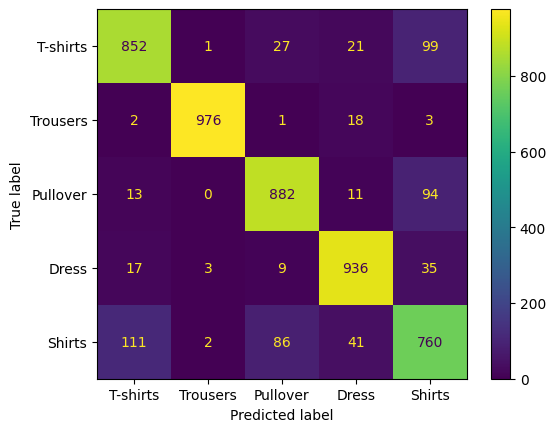

In [13]:
confusion_matrix=confusion_matrix(y_true_classes, y_pred_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['T-shirts','Trousers','Pullover','Dress','Shirts'])
cm_display.plot()